In [1]:
import pandas as pd
from orbit.models import ETS
from orbit.models import DLT
from orbit.diagnostics.backtest import BackTester
from orbit.models import KTR
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error
from math import sqrt
from concurrent.futures import ThreadPoolExecutor
import concurrent
import json
from typing import Any, Callable, Dict, Tuple
import itertools
import sys
from pathlib import Path

parent_dir = Path.cwd().parent.parent

if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))
from shared.metrics import print_evaluation_metrics
from shared.helpers import store_model

/home/samuell/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_path = "../data/parsed_dataset.csv"
date_column = "Date_reported"
target_column = "New_deaths"
df = pd.read_csv(file_path)
df = df[[date_column, target_column, "New_cases_30_days_ago"]]
df = df.groupby(date_column).sum().reset_index()
df = df.dropna()
df[date_column] = pd.to_datetime(df.pop(date_column), format="%Y-%m-%d")
# df.set_index(date_time, inplace=True, drop=False)

data_length = len(df)
train_split = 0.9
train = df.iloc[:int(data_length*train_split)]
test = df.iloc[int(data_length*train_split):]

In [3]:
def evaluate_grid(
    model_function: Callable[[Dict[str, Any], str, str], Any],
    grid: Dict[str, Any],
    train: pd.DataFrame,
    date_column: str,
    target_column: str,
) -> Tuple[Dict[str, Any], float]:
    """
    Evaluate a forecasting model on a given parameter grid.

    This function uses a model creation function to initialize a model with the provided
    grid of parameters, performs backtesting using the provided training data, and computes
    the root mean squared error (RMSE) of the predictions.

    Parameters:
    - model_function (Callable[[Dict[str, Any], str, str], Any]): A function that creates
      a model instance. It should accept a parameter grid, a date column name, and a target
      column name.
    - grid (Dict[str, Any]): A dictionary containing the parameters for the model.
    - train (pd.DataFrame): The training dataset as a Pandas DataFrame.
    - date_column (str): The name of the column in 'train' that contains the date information.
    - target_column (str): The name of the target column in 'train'.

    Returns:
    - Tuple[Dict[str, Any], float]: A tuple containing the grid of parameters and the
      corresponding RMSE score.
    """
    model = model_function(grid, date_column, target_column)

    bt = BackTester(
        df=train, model=model, forecast_len=90, n_splits=5, window_type="rolling"
    )

    bt.fit_predict()
    predicted_df = bt.get_predicted_df()

    score = sqrt(mean_squared_error(predicted_df["actual"], predicted_df["prediction"]))
    return grid, score

In [4]:
param_grid = {
    "seasonality": [None, 90, 180, 360],
    "level_sm_input": [None, 0, 0.3, 0.5, 0.8, 1],
    "seasonality_sm_input": [None, 0, 0.3, 0.5, 0.8, 1],
}
param_values = list(param_grid.values())

all_combinations = list(itertools.product(*param_values))

combinations_as_dicts = [
    dict(zip(param_grid.keys(), combination)) for combination in all_combinations
]

In [5]:
ets_scores = dict()


def ets_function(grid: Dict[str, Any], date_column: str, target_column: str):
    """
    Create an ETS model with the specified parameters.

    Parameters:
    - grid (Dict[str, Any]): A dictionary containing the parameters for the ETS model.
    - date_column (str): The name of the date column.
    - target_column (str): The name of the target column.

    Returns:
    - An instance of the ETS model configured with the given parameters.
    """
    return ETS(
        date_col=date_column,
        response_col=target_column,
        prediction_percentiles=[5, 95],
        seed=1,
        **grid
    )


with ThreadPoolExecutor(max_workers=4) as executor:
    futures = {
        executor.submit(
            evaluate_grid, ets_function, option, train, date_column, target_column
        ): option
        for option in combinations_as_dicts
    }
    for future in concurrent.futures.as_completed(futures):
        option, score = future.result()
        ets_scores[json.dumps(option)] = score

2024-03-31 18:32:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-31 18:32:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-31 18:32:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-31 18:32:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status











































































































chain 1 |██▌       | 00:00 Status





























































chain 4 |██▌       | 00:00 Status










chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)















































































































chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)






















































chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                     

chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     













chain 1 |██████████| 00:00 Sampling completed                     


chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     



chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     










chain 4 |██████████| 00:00 Sampling completed

2024-03-31 18:32:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




2024-03-31 18:32:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2024-03-31 18:32:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































































2024-03-31 18:32:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)





















































chain 1 |██████████| 00:01 Sampling completed
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     
















chain 3 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)2024-03-31 18:32:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










chain 1 |          | 00:00 Status









































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 1 |██████████| 00:01 Sampling completed                   
chain 2 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     



chain 2 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)




chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)



chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     


chain 4 |██████████| 00:00 Sampling completed


2024-03-31 18:32:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2024-03-31 18:32:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-31 18:32:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)


























2024-03-31 18:32:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































































































chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 








chain 3 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)































chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed                   













chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                     

chain 4 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)












chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     









chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                     











chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

2024-03-31 18:32:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

2024-03-31 18:32:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)








2024-03-31 18:32:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                   


chain 4 |██████████| 00:00 Sampling completed


chain 1 |          | 00:00 Status












2024-03-31 18:32:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)












































































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)







chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                   















































chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     









chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


2024-03-31 18:32:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status





chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2024-03-31 18:32:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)











2024-03-31 18:32:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)











2024-03-31 18:32:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































































































chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)




















chain 1 |██████████| 
























































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     



























2024-03-31 18:32:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status











chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     



chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2024-03-31 18:32:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)






















2024-03-31 18:32:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)




2024-03-31 18:32:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                     

chain 4 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)





































chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 3 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)







































2024-03-31 18:32:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status









chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)




















chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   

chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   

chain 2 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)




chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)2024-03-31 18:32:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



chain 2 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)









chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                   

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed








chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status






chain 4 |██▌       | 00:00 Status



2024-03-31 18:32:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



chain 4 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)





2024-03-31 18:32:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











chain 4 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)






















































chain 4 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)










chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     





chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                     











2024-03-31 18:32:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










chain 1 |          | 00:00 Status












































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)




























2024-03-31 18:32:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     









chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                     








chain 4 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 3 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)








chain 1 |██████████| 00:00 Sampling completed50 [ 80%]  (Warmup)
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     






chain 4 |██████████| 00:00 Sampling completed



chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status































chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     











2024-03-31 18:33:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

























chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)res: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 1 |          | 00:00 Status

















chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)





















2024-03-31 18:33:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   







chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 2 |          | 00:00 Statusion: 226 / 250 [ 90%]  (Sampling)
chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)






















chain 1 |██████████| 00:00 Sampling completed                   

chain 2 |██████████| 00:00 Sampling completed


chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                     


chain 2 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

2024-03-31 18:33:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















chain 2 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)





































2024-03-31 18:33:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































2024-03-31 18:33:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

























































































chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     






















chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   

chain 1 |██████████| 00:00 Sampling completed                   












chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                   

2024-03-31 18:33:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




2024-03-31 18:33:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2024-03-31 18:33:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)2024-03-31 18:33:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































































































chain 3 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)

















chain 1 |██████████| 00:00 Sampling completed                   







chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     































chain 1 |██████████| 00:00 Sampling completed                     








chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

















chain 4 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)













chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

2024-03-31 18:33:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-31 18:33:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)res: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































2024-03-31 18:33:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)





















































































































chain 1 |██████████| 00:00 Sampling completed     














































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     





chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                     































































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


2024-03-31 18:33:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     

chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 4 |          | 00:00 Status



2024-03-31 18:33:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)



























chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)


2024-03-31 18:33:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)







































2024-03-31 18:33:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   











chain 2 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)
































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     
















































chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     





























































chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


2024-03-31 18:33:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status


2024-03-31 18:33:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)res: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)









































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                   

































2024-03-31 18:33:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















chain 1 |          | 00:00 Status



































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     





















chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 3 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   


2024-03-31 18:33:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status2024-03-31 18:33:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)





2024-03-31 18:33:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)






























2024-03-31 18:33:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































































































chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed               































chain 1 |██████████| 00:00 Sampling completed                     




chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     














2024-03-31 18:33:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











chain 1 |          | 00:00 Status



















chain 1 |██████████| 00:01 Sampling completed                     








chain 2 |██████████| 00:01 Sampling completed
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                   

chain 4 |██▌       | 00:00 Status














chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     














chain 4 |██████████| 00:00 Sampling completed





2024-03-31 18:33:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)




























chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)















chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)





chain 3 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2024-03-31 18:33:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 1 |          | 00:00 Status













chain 1 |██▌       | 00:00 Status






chain 4 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)2024-03-31 18:33:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)









chain 1 |██████████| 00:00 Sampling completed                   




chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 3 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

chain 3 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)



















chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)













































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

2024-03-31 18:33:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     


chain 3 |██████████| 00:00 Sampling completed                   










chain 4 |██████████| 00:00 Sampling completed


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status







chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     

chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                   


2024-03-31 18:33:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


2024-03-31 18:33:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




















2024-03-31 18:33:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)
















































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)



















































































2024-03-31 18:33:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00






















chain 1 |██████████| 00:00 Sampling completed                   














chain 2 |██████████| 00:00 Sampling completed






























chain 3 |██████████| 00:00 Sampling completed                     
chain 1 |██████████| 00:00 Sampling completed                     













chain 2 |██████████| 00:00 Sampling completed                     





chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                     

chain 4 |██████████| 00:00 Sampling completed                   

chain 4 |██████████| 00:00 Sampling completed


chain 3 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)

























chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                     

2024-03-31 18:33:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-31 18:33:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██▌       | 00:00 Status

















2024-03-31 18:33:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



2024-03-31 18:33:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)
















































































chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampl



















chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   























chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     
















chain 3 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                     


chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

2024-03-31 18:33:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-31 18:33:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status















chain 1 |██▌       | 00:00 Status






chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)
















2024-03-31 18:33:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-31 18:33:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)



























































































































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     





























chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     





























chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

2024-03-31 18:33:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status


chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)


2024-03-31 18:33:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2024-03-31 18:33:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



2024-03-31 18:33:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed             














chain 3 |██▌       | 00:00 Status

chain 2 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)













































































































































chain 2 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

















































































chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                     


























2024-03-31 18:33:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status



























chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     














chain 4 |██████████| 00:00 Sampling completed


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)













chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)g)2024-03-31 18:33:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     


chain 4 |██████████| 00:00 Sampling completed

chain 1 |          | 00:00 Status




chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)


2024-03-31 18:33:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




2024-03-31 18:33:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































































2024-03-31 18:33:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   

chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed    
















































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)







































































































2024-03-31 18:33:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














chain 1 |          | 00:00 Status







chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 4 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 2 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)












chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


















chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     





chain 4 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                   

2024-03-31 18:33:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-31 18:33:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)












2024-03-31 18:33:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)









































2024-03-31 18:33:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)















chain 1 

chain 2 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)









































































































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                     











chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     





























chain 1 |██████████| 00:00 Sampling completed                   


chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

2024-03-31 18:33:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





chain 1 |██▌       | 00:00 Status

chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)
2024-03-31 18:33:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)2024-03-31 18:33:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


chain 3 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)





















































2024-03-31 18:33:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










chain 1 |          | 00:00 Statusion: 226 / 250 [ 90%]  (Sampling)





















chain 1 |██▌       | 00:00 Status






















chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   




chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)
2024-03-31 18:33:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   










chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   

chain 3 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)




















2024-03-31 18:33:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)




chain 1 |██████████| 00:00 Sampling completed                   




chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     



2024-03-31 18:33:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-31 18:33:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)











































































































































2024-03-31 18:33:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

















































































chain 4 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)
















chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                   

















chain 4 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)







































chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     















chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

2024-03-31 18:33:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)2024-03-31 18:33:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)


chain 4 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)2024-03-31 18:33:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































2024-03-31 18:33:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     















chain 1 |██████████| 00:00 Sampling completed                     
chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   

chain 4 |██████████| 00:00 Sampling completed                   

chain 4 |██████████| 00:00 Sampling completed

2024-03-31 18:33:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)
2024-03-31 18:33:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





2024-03-31 18:33:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





chain 2 |          | 00:00 Status2024-03-31 18:33:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































































chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)




































































































































2024-03-31 18:33:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |          | 00:00 Status









































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)



























chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     


chain 4 |██████████| 00:00 Sampling completed                     


chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                   


chain 3 |██████████| 00:00 Sampling completed                     


chain 4 |██████████| 00:00 Sampling completed                   





chain 4 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 4 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

2024-03-31 18:33:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-31 18:33:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-31 18:33:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





























































chain 1 |██▌       | 00:00 Status






















































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2024-03-31 18:33:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































































chain 1 |███████▌  | 00:00 Itera




















chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 1 |██████████| 00:00 Sampling completed                   g)
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     















chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

2024-03-31 18:33:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status


2024-03-31 18:33:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2024-03-31 18:33:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)











































2024-03-31 18:33:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)








































chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)































































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   







chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                     


chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     

chain 3 |██████████| 00:00 Sampling completed                   

chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                     


























chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     














chain 4 |██████████| 00:00 Sampling completed

2024-03-31 18:33:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-31 18:33:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

2024-03-31 18:33:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)

2024-03-31 18:33:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































































































chain 1 |██████████| 00:00 Sampling completed          

chain 4 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)
























































chain 1 |██████████| 00:00 Sampling completed                     










chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     








































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                   












chain 3 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


2024-03-31 18:33:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


2024-03-31 18:33:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)




















chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)2024-03-31 18:33:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-31 18:33:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































ch


chain 4 |          | 00:00 Status




























































chain 4 |██▌       | 00:00 Status










































chain 4 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)











































chain 4 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)











































chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                     


chain 4 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)































chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   















chain 1 |██████████| 00:00 Sampling completed                     












chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

2024-03-31 18:33:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)
2024-03-31 18:33:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)

















2024-03-31 18:33:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)2024-03-31 18:33:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                     

















































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     














chain 4 |██████████| 00:00 Sampling completed


2024-03-31 18:33:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

2024-03-31 18:33:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)

















2024-03-31 18:33:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































2024-03-31 18:33:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































chain 1 |██████████| 00:00 Sampling completed                   


chain 3 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)

































chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   
















































2024-03-31 18:33:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   













chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     




chain 3 |          | 00:00 Status














chain 1 |██████████| 00:00 Sampling completed                     












chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   

chain 2 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)



chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)2024-03-31 18:33:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                   









chain 4 |          | 00:00 Status











2024-03-31 18:33:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







chain 1 |          | 00:00 Status



















2024-03-31 18:33:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)





















































































2024-03-31 18:33:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)













































































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   


















































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   

2024-03-31 18:33:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-31 18:33:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

















2024-03-31 18:33:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)















































































2024-03-31 18:33:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































































































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     
















chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     













chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                     

2024-03-31 18:33:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


2024-03-31 18:33:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)






















2024-03-31 18:33:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-31 18:33:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                   

chain 3 |██████████| 00:00 Sampling completed
chai

chain 1 |          | 00:00 Status






chain 1 |          | 00:00 Status












































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)




























chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   

chain 3 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)














chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)























2024-03-31 18:33:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)
















chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                     

chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


























chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     



















2024-03-31 18:33:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




chain 1 |          | 00:00 Status








chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 1 |██▌       | 00:00 Status


chain 3 |██████████| 00:00 Sampling completed                   



chain 4 |██████████| 00:00 Sampling completed                     


chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)

2024-03-31 18:33:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


2024-03-31 18:33:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                   

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status


2024-03-31 18:33:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)



































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)


















2024-03-31 18:33:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   










































































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     






















































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


chain 3 |██████████| 00:00 Sampling completed                   


chain 4 |██████████| 00:00 Sampling completed                   

2024-03-31 18:33:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-31 18:33:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)



















chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)res: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































2024-03-31 18:33:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































































chain 1 |██████████| 00:00 Sampling completed                   























chain 2 |██████████| 00:00 Samplin






























































chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


























































2024-03-31 18:33:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 1 |          | 00:00 Status














chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)







2024-03-31 18:33:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)




































2024-03-31 18:33:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                     

chain 1 |          | 00:00 Status



















chain 1 |██▌       | 00:00 Status
















chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)2024-03-31 18:33:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   







































2024-03-31 18:33:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

chain 3 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)


























chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status










chain 2 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                     





chain 2 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)2024-03-31 18:33:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 4 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)



































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                   


chain 4 |██████████| 00:00 Sampling completed                   2024-03-31 18:33:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

chain 2 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |          | 00:00 Status























2024-03-31 18:33:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)







































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)




















2024-03-31 18:33:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)




















































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     



chain 4 |██████████| 00:00 Sampling completed



















chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                     












2024-03-31 18:33:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




chain 1 |          | 00:00 Status








chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     






chain 4 |██████████| 00:00 Sampling completed






chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)

2024-03-31 18:33:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)24-03-31 18:33:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   

chain 1 |          | 00:00 Status












































2024-03-31 18:33:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)























chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)






















chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     





chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                     























chain 2 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)2024-03-31 18:33:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 3 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)






















chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     




























2024-03-31 18:33:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





chain 1 |          | 00:00 Status


















chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 1 |██▌       | 00:00 Status





chain 2 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2024-03-31 18:33:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)

2024-03-31 18:33:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































2024-03-31 18:33:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































chain 1 |██████████| 00:00 Sampling completed                     














chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                     



chain 4 |███


































































chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                     



























2024-03-31 18:33:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status













































































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

chain 3 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)



chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)




chain 4 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)
2024-03-31 18:33:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 1 |          | 00:00 Status





chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


chain 4 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)2024-03-31 18:33:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.2024-03-31 18:33:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)

















































chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)









2024-03-31 18:33:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































































































chain 1 






chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                     







































2024-03-31 18:33:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 2 |          | 00:00 Status


















chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                   













chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                     




chain 3 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

2024-03-31 18:33:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-31 18:33:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


























2024-03-31 18:33:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







2024-03-31 18:33:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)



























































































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)


















chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)





chain 2 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)













chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


2024-03-31 18:33:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status







chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)
chain 2 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)2024-03-31 18:33:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)



































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

2024-03-31 18:33:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


























chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)



























































chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)






































chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)
























































chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)























































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed      













2024-03-31 18:34:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














chain 1 |          | 00:00 Status













































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     








chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     






chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

2024-03-31 18:34:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































2024-03-31 18:34:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































2024-03-31 18:34:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































































chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)














































































chain 1 |███████▌  | 00:09 Iteration: 100 / 250 [ 40%]  (Warmup)




















































chain 1 |██████████| 00:09 Iteration: 200 / 250 [ 80%]  (Warmup)
































2024-03-31 18:34:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











chain 1 |          | 00:00 Status











































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     












chain 3 |█████     | 00:09 Iteration:   1 / 250 [  0%]  (Warmup)

















2024-03-31 18:34:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     











































2024-03-31 18:34:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

2024-03-31 18:34:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)







chain 1 |███████▌  | 00:08 Iteration: 100 / 250 [ 40%]  (Warmup)













chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     



























2024-03-31 18:34:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


























































































































































































































































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     


chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

















2024-03-31 18:34:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























2024-03-31 18:34:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     







chain 4 |██████████| 00:10 Sampling completed                     

chain 2 |          | 00:00 Status






















































2024-03-31 18:34:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)
chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)














chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     









2024-03-31 18:34:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





























































































































































































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     















2024-03-31 18:34:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     










chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     

chain 2 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)
2024-03-31 18:34:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































2024-03-31 18:34:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)





chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

2024-03-31 18:34:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status







































































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)






























































































chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)







chain 1 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)
























chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)












chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     














2024-03-31 18:34:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status






























































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     














2024-03-31 18:34:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     












chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     














2024-03-31 18:34:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































2024-03-31 18:34:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































































































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)


































chain 1 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)
































chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)
















































chain 1 |          | 00:06 Iteration: 226 / 250 [ 90%]  (Sampling)




chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████|



























2024-03-31 18:34:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status









































































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     












chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     





































2024-03-31 18:35:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































2024-03-31 18:35:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

































2024-03-31 18:35:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































































































































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     

chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)






chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)



























2024-03-31 18:35:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)
































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     



































2024-03-31 18:35:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status













































































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

chain 2 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)













chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     


chain 3 |██████████| 00:06 Sampling completed                     


chain 4 |██████████| 00:06 Sampling completed                     


2024-03-31 18:35:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































2024-03-31 18:35:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-31 18:35:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































































































































































































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)
































































chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)

























chain 1 |          | 00:06 Iteration: 226 / 250 [ 90%]  (Sampling)




















































































chain 2 |███████▌  | 00:07 Iteration: 100 / 250 [ 40%]  (Warmup)


























chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     





















































2024-03-31 18:35:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-31 18:35:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2024-03-31 18:35:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)
2024-03-31 18:35:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)














chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

2024-03-31 18:35:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



















































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

















































































chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)





















































chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


chain 1 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)












chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

chain 2 |███████▌  | 00:07 Iteration: 100 / 250 [ 40%]  (Warmup)

































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     










































2024-03-31 18:35:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status


2024-03-31 18:35:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2024-03-31 18:35:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed           






















2024-03-31 18:35:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)
























chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)








chain 1 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)2024-03-31 18:35:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































chain 1 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)




















































































































































































































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     









chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     


chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     




































2024-03-31 18:35:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

2024-03-31 18:35:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


chain 1 |          | 00:00 Status















chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


2024-03-31 18:35:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































chain 4 |          | 00:00 Status2024-03-31 18:35:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































































chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)









































chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)






























































































chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)





chain 1 |██████████| 00:02 Sampling completed                     
chain 
















































































2024-03-31 18:35:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     



chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     














chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

chain 4 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)














2024-03-31 18:35:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status






























2024-03-31 18:35:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     












2024-03-31 18:35:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

2024-03-31 18:35:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)












chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)













chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)













































































































































































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed               














































































2024-03-31 18:35:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     











chain 1 |          | 00:00 Status








































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)








chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

2024-03-31 18:35:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































2024-03-31 18:35:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-31 18:35:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)












































































chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)



































































































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |█████


chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     


chain 3 |██████████| 00:03 Sampling completed                     


chain 4 |██████████| 00:03 Sampling completed                     





























































2024-03-31 18:35:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-31 18:35:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)





2024-03-31 18:35:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)











































chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)

















































































































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     





2024-03-31 18:35:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status













chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     



























2024-03-31 18:35:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)













chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)










chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     


chain 1 |██████████| 00:03 Iteration: 200 / 250 [ 80%]  (Warmup)











chain 4 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)



















chain 1 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)



















2024-03-31 18:35:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     











2024-03-31 18:35:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-31 18:35:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     


















2024-03-31 18:35:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































































































































































































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)


















chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)













chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)























chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     


chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     














































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

2024-03-31 18:36:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















chain 1 |          | 00:00 Statusion: 226 / 250 [ 90%]  (Sampling)


2024-03-31 18:36:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2024-03-31 18:36:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

























2024-03-31 18:36:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































































































































































































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)











chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)



2024-03-31 18:36:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)








chain 1 |          | 00:06 Iteration: 226 / 250 [ 90%]  (Sampling)










































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

2024-03-31 18:36:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































































































































































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

2024-03-31 18:36:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



















































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

2024-03-31 18:36:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     




2024-03-31 18:36:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     



























































2024-03-31 18:36:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































































chain 1 |█████     | 00:09 Iteration:   1 / 250 [  0%]  (Warmup)







































chain 1 |███████▌  | 00:10 Iteration: 100 / 250 [ 40%]  (Warmup)


























chain 1 |██████████| 00:10 Iteration: 200 / 250 [ 80%]  (Warmup)




















chain 1 |          | 00:10 Iteration: 226 / 250 [ 90%]  (Sampling)









chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     










2024-03-31 18:36:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status























chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     















chain 1 |██████████| 00:10 Sampling completed                     












chain 2 |██████████| 00:10 Sampling completed
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

2024-03-31 18:36:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































2024-03-31 18:36:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































































































































































chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)



































chain 1 |███████▌  | 00:08 Iteration: 100 / 250 [ 40%]  (Warmup)












chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     


chain 1 |██████████| 00:09 Iteration: 200 / 250 [ 80%]  (Warmup)
































chain 1 |          | 00:09 Iteration: 226 / 250 [ 90%]  (Sampling)











2024-03-31 18:36:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

chain 3 |█████     | 00:09 Iteration:   1 / 250 [  0%]  (Warmup)





















chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     
















2024-03-31 18:36:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status
















2024-03-31 18:36:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     






































2024-03-31 18:36:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)
























































































































chain 1 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)



















chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)














chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     






chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     






2024-03-31 18:36:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status
















2024-03-31 18:36:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)






























chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)













chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)















chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     


chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)
































chain 2 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)

















































































2024-03-31 18:36:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     
















































2024-03-31 18:36:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status






























































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     





















2024-03-31 18:36:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)



























































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

































chain 3 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)







2024-03-31 18:36:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































chain 1 |██████████| 00:03 Iteration: 200 / 250 [ 80%]  (Warmup)














chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     







2024-03-31 18:36:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



































































































































































































































chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)

























































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     









chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)










chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)







chain 1 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)


2024-03-31 18:36:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     













chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


2024-03-31 18:36:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status





2024-03-31 18:36:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     














2024-03-31 18:36:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































































































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     















2024-03-31 18:37:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)















chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |          | 00:06 Iteration: 226 / 250 [ 90%]  (Sampling)







































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     







chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     











2024-03-31 18:37:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



















2024-03-31 18:37:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

2024-03-31 18:37:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































































































































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)



























































chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)













chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)











chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

chain 2 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |          | 00:06 Iteration: 226 / 250 [ 90%]  (Sampling)











2024-03-31 18:37:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     








chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


2024-03-31 18:37:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











chain 1 |          | 00:00 Status


































2024-03-31 18:37:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     























2024-03-31 18:37:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)








































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

chain 2 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)



chain 1 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)





chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)

2024-03-31 18:37:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































chain 1 |          | 00:06 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     







2024-03-31 18:37:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





























































































































































































































































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     








































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     












2024-03-31 18:37:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

2024-03-31 18:37:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)

2024-03-31 18:37:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)













chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)




























































































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Samp
































































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     





















2024-03-31 18:37:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

chain 1 |          | 00:00 Status












chain 1 |██▌       | 00:00 Status












2024-03-31 18:37:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     




























































2024-03-31 18:37:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     







2024-03-31 18:37:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     















chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)2024-03-31 18:37:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)
























chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)









































chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)



































































































































































































































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling complet

chain 2 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)











chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     










chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     










chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

2024-03-31 18:37:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-31 18:37:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























2024-03-31 18:37:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-31 18:37:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































































































































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)





























































































chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)





















2024-03-31 18:37:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)


























chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     


































































2024-03-31 18:37:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status













































































































































































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     















2024-03-31 18:37:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     









2024-03-31 18:37:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     































2024-03-31 18:37:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)



























































chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)
























chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)






















































chain 1 |          | 00:06 Iteration: 226 / 250 [ 90%]  (Sampling)














































































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


chain 1 |██████████| 00:07 Sampling completed                     














chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     














































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     











2024-03-31 18:37:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status















2024-03-31 18:37:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































2024-03-31 18:37:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     












2024-03-31 18:37:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































































































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)

















chain 1 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)




















chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)




















chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)

























































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     










2024-03-31 18:37:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





chain 1 |          | 00:00 Status
























































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     















































2024-03-31 18:38:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     






































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     



2024-03-31 18:38:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-31 18:38:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)




chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     































2024-03-31 18:38:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status































































































































































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     





























































chain 1 |███████▌  | 00:03 Iteration: 100 / 250 [ 40%]  (Warmup)2024-03-31 18:38:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


chain 1 |██████████| 00:03 Iteration: 200 / 250 [ 80%]  (Warmup)
















































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     





































2024-03-31 18:38:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status












chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


2024-03-31 18:38:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































2024-03-31 18:38:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































































































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)


























































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     
























chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)















chain 1 |          | 00:06 Iteration: 226 / 250 [ 90%]  (Sampling)2024-03-31 18:38:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

2024-03-31 18:38:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     













chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     











2024-03-31 18:38:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


















2024-03-31 18:38:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































































































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     








chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     



2024-03-31 18:38:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2024-03-31 18:38:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































































chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)

























































































chain 1 |███████▌  | 00:08 Iteration: 100 / 250 [ 40%]  (Warmup)











chain 1 |██████████| 00:08 Iteration: 200 / 250 [ 80%]  (Warmup)










chain 1 |          | 00:08 Iteration: 226 / 250 [ 90%]  (Sampling)











































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████
















chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     








2024-03-31 18:38:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status


2024-03-31 18:38:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































































































































chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)



































































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

















chain 4 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)









chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)























chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)















2024-03-31 18:38:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     










chain 4 |██████████| 00:10 Sampling completed                     


chain 1 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)



chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     















chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

2024-03-31 18:38:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







chain 1 |          | 00:00 Status



2024-03-31 18:38:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-31 18:38:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































































































































































































chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)









































chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)
























chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)


























chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


chain 1 |██████████| 00:04 Sampling completed                     


chain 2 |██████████| 00:04 Sampling completed                     


chain 3 |██████████| 00:04 Sampling completed                     


chain 4 |██████████| 00:04 Sampling completed                     







chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     

2024-03-31 18:38:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-31 18:38:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















chain 4 |          | 00:00 Status2024-03-31 18:38:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.2024-03-31 18:38:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































































































































































chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 4












































2024-03-31 18:38:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



chain 1 |          | 00:00 Status





































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     























2024-03-31 18:38:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2024-03-31 18:38:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

2024-03-31 18:38:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)
















chain 1 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)









































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     







2024-03-31 18:38:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















chain 1 |          | 00:00 Status





























































































































































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     











chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     














2024-03-31 18:38:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     





2024-03-31 18:38:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































2024-03-31 18:38:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)





chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

2024-03-31 18:38:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status













































































































































































































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     












2024-03-31 18:39:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     
















































2024-03-31 18:39:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

2024-03-31 18:39:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)































































































chain 1 |███████▌  | 00:08 Iteration: 100 / 250 [ 40%]  (Warmup)






































chain 1 |██████████| 00:08 Iteration: 200 / 250 [ 80%]  (Warmup)
































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     







chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     





















































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


2024-03-31 18:39:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status












chain 3 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)2024-03-31 18:39:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































2024-03-31 18:39:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

2024-03-31 18:39:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































































































































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)


































































































































































chain 1 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)






























chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     












chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)

























































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     


2024-03-31 18:39:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















chain 1 |          | 00:00 Status


chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

chain 2 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)

2024-03-31 18:39:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































2024-03-31 18:39:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)







chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)







chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)







chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     







2024-03-31 18:39:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































































































































chain 1 |██████████| 00:04 Sampling completed                     

chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     














chain 2 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)




























































































2024-03-31 18:39:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     



























































chain 1 |██████████| 00:03 Iteration: 200 / 250 [ 80%]  (Warmup)2024-03-31 18:39:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







chain 1 |          | 00:00 Status

































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     














chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

2024-03-31 18:39:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































2024-03-31 18:39:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)



























































chain 1 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)




















chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     












chain 1 |          | 00:06 Iteration: 226 / 250 [ 90%]  (Sampling)


































































2024-03-31 18:39:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

2024-03-31 18:39:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












chain 1 |          | 00:00 Status


2024-03-31 18:39:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

2024-03-31 18:39:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































































































































































































chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)





















































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     


chain 1 |███████▌  | 00:07 Iteration: 100 / 250 [ 40%]  (Warmup)

























chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)2024-03-31 18:39:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     













2024-03-31 18:39:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





















































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     
























2024-03-31 18:39:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

2024-03-31 18:39:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)

















chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)



















































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     















2024-03-31 18:39:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

chain 3 |          | 00:00 Status
























2024-03-31 18:39:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































































































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     



























2024-03-31 18:39:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

2024-03-31 18:39:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)

























chain 1 |███████▌  | 00:07 Iteration: 100 / 250 [ 40%]  (Warmup)








chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)









chain 1 |          | 00:08 Iteration: 226 / 250 [ 90%]  (Sampling)







































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     























chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     


2024-03-31 18:39:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status















2024-03-31 18:39:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































































































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)






























































































































chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)





























chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)

































chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)








chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 

2024-03-31 18:40:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     



chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     









2024-03-31 18:40:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





2024-03-31 18:40:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

2024-03-31 18:40:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     












chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     













chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)























2024-03-31 18:40:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































































































chain 1 |███████▌  | 00:09 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |          | 00:10 Iteration: 226 / 250 [ 90%]  (Sampling)





















































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     

















chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     


2024-03-31 18:40:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status








2024-03-31 18:40:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     































2024-03-31 18:40:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































































































































































































































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     

chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)










2024-03-31 18:40:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |███████▌  | 00:09 Iteration: 100 / 250 [ 40%]  (Warmup)










































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     


chain 1 |██████████| 00:10 Iteration: 200 / 250 [ 80%]  (Warmup)




chain 1 |          | 00:10 Iteration: 226 / 250 [ 90%]  (Sampling)








2024-03-31 18:40:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     

2024-03-31 18:40:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





2024-03-31 18:40:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































































































































chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)





































































































































































chain 1 |███████▌  | 00:07 Iteration: 100 / 250 [ 40%]  (Warmup)
































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed 

chain 1 |          | 00:08 Iteration: 226 / 250 [ 90%]  (Sampling)








chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     


2024-03-31 18:40:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































2024-03-31 18:40:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































































































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     


























































































2024-03-31 18:40:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     










2024-03-31 18:40:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     











2024-03-31 18:40:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










chain 1 |          | 00:00 Status






































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)














2024-03-31 18:40:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)




chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)
















chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     












2024-03-31 18:40:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













chain 1 |          | 00:00 Status












































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)









chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)













chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)





































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

chain 2 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)





















































2024-03-31 18:40:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     












chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

2024-03-31 18:40:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status
































2024-03-31 18:40:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































































































































































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)














2024-03-31 18:41:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)



















chain 1 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)











chain 1 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)

































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     






chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

2024-03-31 18:41:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























2024-03-31 18:41:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     


























































































2024-03-31 18:41:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










chain 1 |          | 00:00 Status








































































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     

2024-03-31 18:41:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)

































2024-03-31 18:41:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)



















chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     
















chain 1 |███████▌  | 00:03 Iteration: 100 / 250 [ 40%]  (Warmup)




2024-03-31 18:41:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































chain 1 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)



































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


chain 1 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)

















2024-03-31 18:41:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     





































2024-03-31 18:41:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status








chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

chain 3 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)
































2024-03-31 18:41:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     


























2024-03-31 18:41:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































































































































































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     




chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

2024-03-31 18:41:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































2024-03-31 18:41:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































































































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     






































2024-03-31 18:41:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)
























































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     

chain 1 |███████▌  | 00:10 Iteration: 100 / 250 [ 40%]  (Warmup)

















2024-03-31 18:41:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































chain 1 |██████████| 00:10 Iteration: 200 / 250 [ 80%]  (Warmup)



















































chain 1 |          | 00:11 Iteration: 226 / 250 [ 90%]  (Sampling)



chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     




























2024-03-31 18:41:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













chain 1 |          | 00:00 Status


































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     

































































2024-03-31 18:41:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































































chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)






chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     
























chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     












































2024-03-31 18:41:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-31 18:41:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































chain 1 |███████▌  | 00:03 Iteration: 100 / 250 [ 40%]  (Warmup)












chain 1 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)












































































































































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     









































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     









2024-03-31 18:41:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status
















2024-03-31 18:41:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     










chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     










































chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)
2024-03-31 18:41:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2024-03-31 18:41:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































































chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)















































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     






















































2024-03-31 18:41:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status







































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


















2024-03-31 18:41:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)
























































chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)






































chain 1 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)
























chain 1 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)






























































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     







2024-03-31 18:41:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












chain 1 |          | 00:00 Status


chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     





2024-03-31 18:41:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































2024-03-31 18:41:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)






































































































chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)









chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)
















































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     







































2024-03-31 18:41:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     










chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)



































































2024-03-31 18:41:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status









chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     












































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2024-03-31 18:41:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     












2024-03-31 18:41:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































































































chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)



















chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)










































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


















chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

2024-03-31 18:41:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status


2024-03-31 18:41:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)
































chain 1 |███████▌  | 00:03 Iteration: 100 / 250 [ 40%]  (Warmup)





















chain 1 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)































chain 1 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)









































































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling co

chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     




































2024-03-31 18:42:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status















2024-03-31 18:42:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

chain 1 |          | 00:00 Status












































































2024-03-31 18:42:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































































































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)






chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     

chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)



chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)2024-03-31 18:42:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































chain 1 |          | 00:06 Iteration: 226 / 250 [ 90%]  (Sampling)




























































































































































































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     



chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     































2024-03-31 18:42:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









chain 1 |          | 00:00 Status










2024-03-31 18:42:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































































































































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     









chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     














2024-03-31 18:42:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2024-03-31 18:42:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































































































































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     



2024-03-31 18:42:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































chain 1 |█████     | 00:10 Iteration:   1 / 250 [  0%]  (Warmup)










chain 1 |███████▌  | 00:10 Iteration: 100 / 250 [ 40%]  (Warmup)







chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

2024-03-31 18:42:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status










































































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     




2024-03-31 18:42:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































































































































































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

chain 3 |███████▌  | 00:09 Iteration: 100 / 250 [ 40%]  (Warmup)











chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)












2024-03-31 18:42:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     


chain 1 |███████▌  | 00:08 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |          | 00:08 Iteration: 226 / 250 [ 90%]  (Sampling)2024-03-31 18:42:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































































































chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     






































2024-03-31 18:42:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








chain 1 |          | 00:00 Status













































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     














2024-03-31 18:42:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

2024-03-31 18:42:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     

2024-03-31 18:42:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































































































































































chain 1 |█████     | 00:12 Iteration:   1 / 250 [  0%]  (Warmup)




























































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

























chain 1 |██████████| 00:13 Iteration: 200 / 250 [ 80%]  (Warmup)
2024-03-31 18:42:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































chain 1 |          | 00:13 Iteration: 226 / 250 [ 90%]  (Sampling)












chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     












































2024-03-31 18:42:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status









chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     


















2024-03-31 18:42:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)


























chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

2024-03-31 18:42:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)








chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)



















































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     












































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     











chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

chain 2 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)

2024-03-31 18:43:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status




































2024-03-31 18:43:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































































































































































































































chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)













chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     














chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     


2024-03-31 18:43:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































chain 1 |███████▌  | 00:03 Iteration: 100 / 250 [ 40%]  (Warmup)





chain 1 |██████████| 00:03 Iteration: 200 / 250 [ 80%]  (Warmup)2024-03-31 18:43:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)













chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     



chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

chain 3 |          | 00:00 Status















2024-03-31 18:43:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

2024-03-31 18:43:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status











































































































































































































chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)














































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     




















chain 1 |███████▌  | 00:03 Iteration: 100 / 250 [ 40%]  (Warmup)










chain 1 |██████████| 00:03 Iteration: 200 / 250 [ 80%]  (Warmup)2024-03-31 18:43:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































chain 1 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)


















































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     










chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

















chain 4 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)

2024-03-31 18:43:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















chain 1 |          | 00:00 Status




































2024-03-31 18:43:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































2024-03-31 18:43:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

2024-03-31 18:43:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































chain 1 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)

















































































































































































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

























chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     
























2024-03-31 18:43:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status




























2024-03-31 18:43:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     














2024-03-31 18:43:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

2024-03-31 18:43:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)







































































































































































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     





















chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     















2024-03-31 18:43:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












chain 1 |          | 00:00 Status



























































2024-03-31 18:43:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     












chain 2 |██████████| 00:08 Iteration: 200 / 250 [ 80%]  (Warmup)










chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

2024-03-31 18:43:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































2024-03-31 18:43:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































































































































chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)





























































chain 1 |███████▌  | 00:07 Iteration: 100 / 250 [ 40%]  (Warmup)









chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed            


















chain 1 |          | 00:08 Iteration: 226 / 250 [ 90%]  (Sampling)





















chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     







2024-03-31 18:43:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































2024-03-31 18:43:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     








2024-03-31 18:43:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status





























chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     







































2024-03-31 18:43:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)


























































chain 1 |██████████| 00:03 Iteration: 200 / 250 [ 80%]  (Warmup)





























































chain 1 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)


























































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     






















chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

2024-03-31 18:43:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































2024-03-31 18:43:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     



















2024-03-31 18:43:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status






























chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)











































chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)





chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)



chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     


chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)






























2024-03-31 18:43:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

chain 4 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)








































2024-03-31 18:43:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














chain 1 |          | 00:00 Status

















chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     

chain 4 |██████████| 00:07 Sampling completed                     

chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)





















































































2024-03-31 18:43:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

2024-03-31 18:43:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)



































chain 1 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)




















chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)














chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)















chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     


chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     

2024-03-31 18:44:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































2024-03-31 18:44:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     









2024-03-31 18:44:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status

































































































































































































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     

















2024-03-31 18:44:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)














































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

2024-03-31 18:44:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































chain 1 |██████████| 00:09 Iteration: 200 / 250 [ 80%]  (Warmup)















chain 1 |          | 00:09 Iteration: 226 / 250 [ 90%]  (Sampling)























































































































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     

















chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

2024-03-31 18:44:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





2024-03-31 18:44:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































































chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     








































2024-03-31 18:44:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































































































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     
















chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     


2024-03-31 18:44:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)2024-03-31 18:44:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     













2024-03-31 18:44:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status








































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     































2024-03-31 18:44:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































































































































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     













chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     













chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)













2024-03-31 18:44:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































2024-03-31 18:44:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)





chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

2024-03-31 18:44:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |          | 00:08 Iteration: 226 / 250 [ 90%]  (Sampling)
























chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     





























































2024-03-31 18:44:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


























































































chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)










































































chain 1 |███████▌  | 00:03 Iteration: 100 / 250 [ 40%]  (Warmup)









































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     




















chain 1 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)
















2024-03-31 18:44:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

2024-03-31 18:44:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status






























chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

2024-03-31 18:44:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     














2024-03-31 18:44:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































































































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)
































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     





























2024-03-31 18:44:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































chain 1 |███████▌  | 00:08 Iteration: 100 / 250 [ 40%]  (Warmup)





chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

chain 1 |██████████| 00:08 Iteration: 200 / 250 [ 80%]  (Warmup)





2024-03-31 18:44:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

2024-03-31 18:44:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




















































































































































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)




































































chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)









chain 1 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)





































chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)




























chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed              






chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     
















chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     


2024-03-31 18:45:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status


2024-03-31 18:45:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██▌       | 00:00 Status



































2024-03-31 18:45:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     












2024-03-31 18:45:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































































































































































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     
























2024-03-31 18:45:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































































chain 1 |█████     | 00:10 Iteration:   1 / 250 [  0%]  (Warmup)









chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     














chain 1 |███████▌  | 00:11 Iteration: 100 / 250 [ 40%]  (Warmup)






chain 1 |██████████| 00:11 Iteration: 200 / 250 [ 80%]  (Warmup)2024-03-31 18:45:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































chain 1 |          | 00:11 Iteration: 226 / 250 [ 90%]  (Sampling)





























chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     


























2024-03-31 18:45:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




























































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)







































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     













2024-03-31 18:45:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)2024-03-31 18:45:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































































chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)



















chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)









































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

chain 1 |          | 00:06 Iteration: 226 / 250 [ 90%]  (Sampling)















































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     













2024-03-31 18:45:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status













chain 1 |██▌       | 00:00 Status













































2024-03-31 18:45:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     






chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     













2024-03-31 18:45:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-31 18:45:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































































































































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)











































































chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)





chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


chain 1 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

2024-03-31 18:45:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







chain 1 |          | 00:00 Status





















2024-03-31 18:45:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































































































































































































































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)










































chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)




















chain 1 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)





















































































chain 1 |██████████| 00:09 Sampling completed 







chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     























chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

2024-03-31 18:45:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-31 18:45:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































































































2024-03-31 18:45:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

2024-03-31 18:45:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





























































































































































































































































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)
























chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)





























chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)
















chain 1 |          | 00:06 Iteration: 226 / 250 [ 90%]  (Sampling)





















































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling compl



2024-03-31 18:45:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     











chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     




2024-03-31 18:45:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-31 18:45:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

2024-03-31 18:45:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































































































































































































































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     















2024-03-31 18:45:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     











chain 1 |█████     | 00:09 Iteration:   1 / 250 [  0%]  (Warmup)2024-03-31 18:45:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































chain 1 |██████████| 00:10 Iteration: 200 / 250 [ 80%]  (Warmup)










chain 1 |          | 00:10 Iteration: 226 / 250 [ 90%]  (Sampling)

























chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     







































2024-03-31 18:45:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status















chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

2024-03-31 18:45:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































































































































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)





























2024-03-31 18:46:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)













chain 1 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)


























































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     


chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     









chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     











2024-03-31 18:46:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



















2024-03-31 18:46:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




2024-03-31 18:46:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































































































































































































































































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)



































































































chain 1 |██████████| 00:06 Sampling completed                     


chain 2 |██████████| 00:06 Sampling completed                     


chain 3 |██████████| 00:06 Sampling completed                     


chain 4 |██████████| 00:06 Sampling completed                     





chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)



















chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     


2024-03-31 18:46:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



2024-03-31 18:46:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     


chain 1 |          | 00:00 Status






















chain 1 |██▌       | 00:00 Status














2024-03-31 18:46:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































2024-03-31 18:46:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































































































































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)

























































































chain 1 |███████▌  | 00:07 Iteration: 100 / 250 [ 40%]  (Warmup)






















chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)











































































































































2024-03-31 18:46:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     






















chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     













chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

2024-03-31 18:46:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-31 18:46:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status












































2024-03-31 18:46:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































































































































































































































































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling compl

















2024-03-31 18:46:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

2024-03-31 18:46:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































chain 1 |█████     | 00:09 Iteration:   1 / 250 [  0%]  (Warmup)





































































































chain 1 |██████████| 00:11 Iteration: 200 / 250 [ 80%]  (Warmup)





















chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     












2024-03-31 18:46:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:12 Iteration: 226 / 250 [ 90%]  (Sampling)










chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     

chain 2 |          | 00:00 Status



































2024-03-31 18:46:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     










chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

2024-03-31 18:46:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









2024-03-31 18:46:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































































































chain 2 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)







chain 2 |██████████| 00:10 Iteration: 200 / 250 [ 80%]  (Warmup)













chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     




























2024-03-31 18:46:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




























































































































































































































































































chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     




















2024-03-31 18:46:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     








chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

2024-03-31 18:46:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)








2024-03-31 18:46:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































chain 1 |██████████| 00:10 Iteration: 200 / 250 [ 80%]  (Warmup)











chain 1 |          | 00:11 Iteration: 226 / 250 [ 90%]  (Sampling)





















































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     






2024-03-31 18:47:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status














































































































































































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     



































2024-03-31 18:47:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     







2024-03-31 18:47:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     
















chain 1 |███████▌  | 00:08 Iteration: 100 / 250 [ 40%]  (Warmup)2024-03-31 18:47:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































chain 1 |          | 00:09 Iteration: 226 / 250 [ 90%]  (Sampling)
































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

2024-03-31 18:47:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





































































































































































chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)





















































chain 1 |███████▌  | 00:08 Iteration: 100 / 250 [ 40%]  (Warmup)










chain 1 |██████████| 00:08 Iteration: 200 / 250 [ 80%]  (Warmup)


























chain 1 |          | 00:08 Iteration: 226 / 250 [ 90%]  (Sampling)






































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed               

chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     


2024-03-31 18:47:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status














2024-03-31 18:47:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     



























2024-03-31 18:47:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     

2024-03-31 18:47:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































chain 1 |█████     | 00:09 Iteration:   1 / 250 [  0%]  (Warmup)
























chain 1 |███████▌  | 00:11 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:11 Iteration: 200 / 250 [ 80%]  (Warmup)




















chain 1 |          | 00:12 Iteration: 226 / 250 [ 90%]  (Sampling)





































































































































































































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed          







chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     














chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     

















chain 4 |███████▌  | 00:12 Iteration: 100 / 250 [ 40%]  (Warmup)















2024-03-31 18:47:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













chain 1 |          | 00:00 Status


2024-03-31 18:47:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































2024-03-31 18:47:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     

2024-03-31 18:47:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































































chain 1 |█████     | 00:10 Iteration:   1 / 250 [  0%]  (Warmup)














































chain 1 |██████████| 00:13 Iteration: 200 / 250 [ 80%]  (Warmup)





chain 1 |          | 00:13 Iteration: 226 / 250 [ 90%]  (Sampling)





















































































































































































































chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████


chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     
































chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     








2024-03-31 18:47:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-31 18:47:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status

































2024-03-31 18:47:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































































chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     

2024-03-31 18:48:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)
















































































chain 1 |███████▌  | 00:03 Iteration: 100 / 250 [ 40%]  (Warmup)















chain 1 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)































































































































































































































































































chain 1 |██████████| 00:02 Sampling completed                     









chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                   





chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


2024-03-31 18:48:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







2024-03-31 18:48:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     






chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     


























chain 1 |          | 00:00 Statusing (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























2024-03-31 18:48:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































































































































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)








2024-03-31 18:48:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































































































chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)













































chain 1 |██████████| 00:03 Iteration: 200 / 250 [ 80%]  (Warmup)









































chain 1 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)








chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     











chain 3 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)

























chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


































chain 1 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)2024-03-31 18:48:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































chain 1 |          | 00:00 Status







































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

2024-03-31 18:48:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































2024-03-31 18:48:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     






















chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)



chain 3 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2024-03-31 18:48:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)











chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)









chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

















2024-03-31 18:48:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status























chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     











chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

2024-03-31 18:48:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)































chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)




































chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)






































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     




























chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     












chain 4 |██████████| 00:05 Sampling completed                     

chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)
























chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     


2024-03-31 18:48:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















chain 4 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)

2024-03-31 18:48:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status








































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

2024-03-31 18:48:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































2024-03-31 18:48:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































































































































































chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)















chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     
























chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

2024-03-31 18:48:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |███████▌  | 00:03 Iteration: 100 / 250 [ 40%]  (Warmup)
















chain 1 |██████████| 00:03 Iteration: 200 / 250 [ 80%]  (Warmup)2024-03-31 18:48:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































chain 1 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)

















































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     














































2024-03-31 18:48:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











chain 1 |          | 00:00 Status





































































































































































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     











chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     













chain 4 |██████████| 00:02 Sampling completed                     





























chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     


chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     


2024-03-31 18:48:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















2024-03-31 18:48:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































2024-03-31 18:48:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































































































































































































































































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     









chain 1 |██████████| 00:02 Sampling completed                     




chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     



2024-03-31 18:48:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)2024-03-31 18:48:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































































chain 1 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)







chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)











chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     





chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     











































































2024-03-31 18:48:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status











































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     






















chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

















chain 4 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)

2024-03-31 18:48:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2024-03-31 18:48:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































































chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)











chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     






















chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)







chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)



2024-03-31 18:48:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     



















































2024-03-31 18:48:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status










































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     










chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)



























chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

2024-03-31 18:48:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















2024-03-31 18:48:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































































































chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)











chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)






















chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed          

































chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)





2024-03-31 18:48:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     





































2024-03-31 18:48:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















chain 1 |          | 00:00 Status




























































































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)













chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)
















































2024-03-31 18:48:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)



























chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)


















chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)













chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     












2024-03-31 18:48:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     






2024-03-31 18:48:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




















































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)




















chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     



















































2024-03-31 18:48:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)
























chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)





































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     




chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)


























chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

2024-03-31 18:48:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status
















2024-03-31 18:48:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

































































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     


chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)














chain 2 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)
















2024-03-31 18:48:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)


























































































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

















chain 1 |          | 00:00 Statusion:   1 / 250 [  0%]  (Warmup)2024-03-31 18:48:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     








2024-03-31 18:48:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


















































chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)






chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     






chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)

2024-03-31 18:48:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

2024-03-31 18:48:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status











































































































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     












2024-03-31 18:48:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































































































































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)













chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     










2024-03-31 18:48:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)






























































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

2024-03-31 18:48:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





2024-03-31 18:48:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































































































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     












2024-03-31 18:48:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     







2024-03-31 18:48:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)

















chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)





chain 1 |          | 00:06 Iteration: 226 / 250 [ 90%]  (Sampling)










chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

2024-03-31 18:48:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     



































2024-03-31 18:49:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







chain 1 |          | 00:00 Status





















chain 1 |██▌       | 00:00 Status









































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     





































2024-03-31 18:49:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     








2024-03-31 18:49:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

2024-03-31 18:49:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)































































































































































chain 1 |███████▌  | 00:10 Iteration: 100 / 250 [ 40%]  (Warmup)






















chain 1 |██████████| 00:10 Iteration: 200 / 250 [ 80%]  (Warmup)


























chain 1 |          | 00:10 Iteration: 226 / 250 [ 90%]  (Sampling)




chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     























































chain 1 |          | 00:00 Statusing (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     






























chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     










chain 2 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)2024-03-31 18:49:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































2024-03-31 18:49:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

2024-03-31 18:49:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)



















































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     


chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)2024-03-31 18:49:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

2024-03-31 18:49:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




































































































































































































































































chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)





























































































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     

























chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     


chain 1 |███████▌  | 00:03 Iteration: 100 / 250 [ 40%]  (Warmup)




chain 1 |██████████| 00:03 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

chain 4 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)




2024-03-31 18:49:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

2024-03-31 18:49:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     

chain 1 |          | 00:00 Status




















2024-03-31 18:49:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































2024-03-31 18:49:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)
























chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)













chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)




















































chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)



























































































































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     












chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     







chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


























2024-03-31 18:49:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-31 18:49:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












chain 1 |          | 00:00 Status
























































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

2024-03-31 18:49:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































2024-03-31 18:49:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)

























chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)




















chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)





chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)























































































































































































































chain 1 |██████████| 00:06 Sampling completed                     






































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     



















chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     





























































2024-03-31 18:49:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status















2024-03-31 18:49:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















2024-03-31 18:49:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

2024-03-31 18:49:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































































































































































































































































chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)
























































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

chain 1 |███████▌  | 00:08 Iteration: 100 / 250 [ 40%]  (Warmup)2024-03-31 18:49:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     


chain 1 |██████████| 00:08 Iteration: 200 / 250 [ 80%]  (Warmup)












chain 1 |██████████| 00:09 Sampling completed                     











chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

chain 1 |          | 00:00 Statusion: 100 / 250 [ 40%]  (Warmup)2024-03-31 18:49:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














2024-03-31 18:49:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

2024-03-31 18:49:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































































































































































































































































chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)





































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     
























2024-03-31 18:49:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |███████▌  | 00:07 Iteration: 100 / 250 [ 40%]  (Warmup)































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     


chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)












chain 1 |          | 00:08 Iteration: 226 / 250 [ 90%]  (Sampling)





















2024-03-31 18:49:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     





































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

2024-03-31 18:49:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





2024-03-31 18:49:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)


























































chain 1 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)













chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     


chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)




chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)2024-03-31 18:50:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


































2024-03-31 18:50:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status
































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     














2024-03-31 18:50:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

2024-03-31 18:50:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     





chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)





2024-03-31 18:50:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)








chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)









































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     





















chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     


chain 4 |██████████| 00:05 Sampling completed                     














2024-03-31 18:50:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status














chain 1 |██▌       | 00:00 Status









































2024-03-31 18:50:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

















2024-03-31 18:50:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































































































































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)
























































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)

































chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)2024-03-31 18:50:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     






















































2024-03-31 18:50:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     




chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

2024-03-31 18:50:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





2024-03-31 18:50:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































































































































































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     
















2024-03-31 18:50:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     








chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)



















































2024-03-31 18:50:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































































chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)










chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)










chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

























2024-03-31 18:50:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status












































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

























2024-03-31 18:50:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































































































































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     


chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)




chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     





































2024-03-31 18:50:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































2024-03-31 18:50:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)



























chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)


























































chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)

































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling
















chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     

chain 4 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)










chain 1 |          | 00:00 Statusion:   1 / 250 [  0%]  (Warmup)2024-03-31 18:50:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


2024-03-31 18:50:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


















2024-03-31 18:50:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































































































































































































































































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)
















chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     





chain 4 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)

2024-03-31 18:50:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































chain 1 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)2024-03-31 18:50:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)




















chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)





chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     








2024-03-31 18:50:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



chain 1 |          | 00:00 Status







































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     

2024-03-31 18:50:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































































































































































chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)
























































































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     









chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     


chain 1 |███████▌  | 00:03 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:03 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)
2024-03-31 18:50:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































2024-03-31 18:50:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     

2024-03-31 18:50:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status











































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     








2024-03-31 18:50:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)






























































































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


chain 1 |███████▌  | 00:03 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:03 Iteration: 200 / 250 [ 80%]  (Warmup)














chain 1 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)

2024-03-31 18:50:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     








































2024-03-31 18:50:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status
















































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

2024-03-31 18:50:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































































































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)




















































































chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)








chain 1 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)





















chain 1 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)





chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     










chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


























chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     


2024-03-31 18:50:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status





























chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)2024-03-31 18:50:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































2024-03-31 18:51:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

2024-03-31 18:51:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)






















































chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)






































chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)




























































chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)












chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     






























2024-03-31 18:51:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status










chain 1 |██▌       | 00:00 Status
































































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

chain 2 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     











2024-03-31 18:51:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     



2024-03-31 18:51:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)
2024-03-31 18:51:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































chain 1 |███████▌  | 00:03 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)






chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)






















chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

2024-03-31 18:51:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


































































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     
















































2024-03-31 18:51:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































































































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)

































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     






2024-03-31 18:51:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)
















chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)
















chain 1 |          | 00:06 Iteration: 226 / 250 [ 90%]  (Sampling)























































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     






2024-03-31 18:51:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     






























2024-03-31 18:51:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status










































































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     













2024-03-31 18:51:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































































































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     






















2024-03-31 18:51:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     


chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)
















2024-03-31 18:51:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































chain 1 |███████▌  | 00:07 Iteration: 100 / 250 [ 40%]  (Warmup)





















chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)












chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     













chain 1 |          | 00:08 Iteration: 226 / 250 [ 90%]  (Sampling)




















2024-03-31 18:51:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































































































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     








































2024-03-31 18:51:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


















































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     
















chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     








2024-03-31 18:51:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







2024-03-31 18:51:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































































































































































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     













2024-03-31 18:51:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































































chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)































chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)

























chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)













































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     











2024-03-31 18:51:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     














chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     












chain 3 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)










chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     


2024-03-31 18:51:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status





























2024-03-31 18:51:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























2024-03-31 18:51:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)








































chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)










chain 1 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)







































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |█

























chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     













chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

2024-03-31 18:51:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



chain 2 |██▌       | 00:00 Status2024-03-31 18:51:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































2024-03-31 18:51:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































































chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)









chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)





chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)





chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)
















































































2024-03-31 18:51:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     



chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

2024-03-31 18:51:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-31 18:51:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




























































































































































































































































































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     



2024-03-31 18:52:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)

































chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)






































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     
















chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     
















2024-03-31 18:52:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


















2024-03-31 18:52:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































2024-03-31 18:52:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

2024-03-31 18:52:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)








































































































































































































chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)


























chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)















chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     






















chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     
































2024-03-31 18:52:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     





chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

2024-03-31 18:52:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























2024-03-31 18:52:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































2024-03-31 18:52:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































chain 1 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)



























chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

2024-03-31 18:52:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



































































































































































































































































































































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)





































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     


chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     





chain 2 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)












chain 1 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)











2024-03-31 18:52:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)





























chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     




chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

2024-03-31 18:52:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status













chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)








































chain 1 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)




















chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     











chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

2024-03-31 18:52:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)








chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

In [6]:
ets_best_params = json.loads(min(ets_scores, key=ets_scores.get))
ets_scores

{'{"seasonality": null, "level_sm_input": null, "seasonality_sm_input": 0}': 2480.4686893393605,
 '{"seasonality": null, "level_sm_input": null, "seasonality_sm_input": 0.5}': 2455.1880115010354,
 '{"seasonality": null, "level_sm_input": null, "seasonality_sm_input": null}': 2447.541483375662,
 '{"seasonality": null, "level_sm_input": null, "seasonality_sm_input": 0.3}': 2467.7041864173043,
 '{"seasonality": null, "level_sm_input": null, "seasonality_sm_input": 0.8}': 2481.544871092647,
 '{"seasonality": null, "level_sm_input": null, "seasonality_sm_input": 1}': 2468.295317143798,
 '{"seasonality": null, "level_sm_input": 0, "seasonality_sm_input": 0}': 6069.050645453549,
 '{"seasonality": null, "level_sm_input": 0, "seasonality_sm_input": null}': 6053.665099300351,
 '{"seasonality": null, "level_sm_input": 0, "seasonality_sm_input": 0.3}': 6080.642046704295,
 '{"seasonality": null, "level_sm_input": 0, "seasonality_sm_input": 0.5}': 6075.342321056743,
 '{"seasonality": null, "level_sm

In [28]:
ets_best_params

In [29]:
ets = ETS(
    date_col=date_column,
    response_col=target_column,
    prediction_percentiles=[5, 95],
    seed=1,
    **ets_best_params
)
train_ets = train[[date_column, target_column]].copy()

ets.fit(df=train_ets)

2024-04-06 12:54:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |███████▌  | 00:03 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 00:03 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)


chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     

In [41]:
forecast_df = test[[date_column]]
p = ets.predict(df=forecast_df)
p = p.merge(test, on=date_column, how="left")

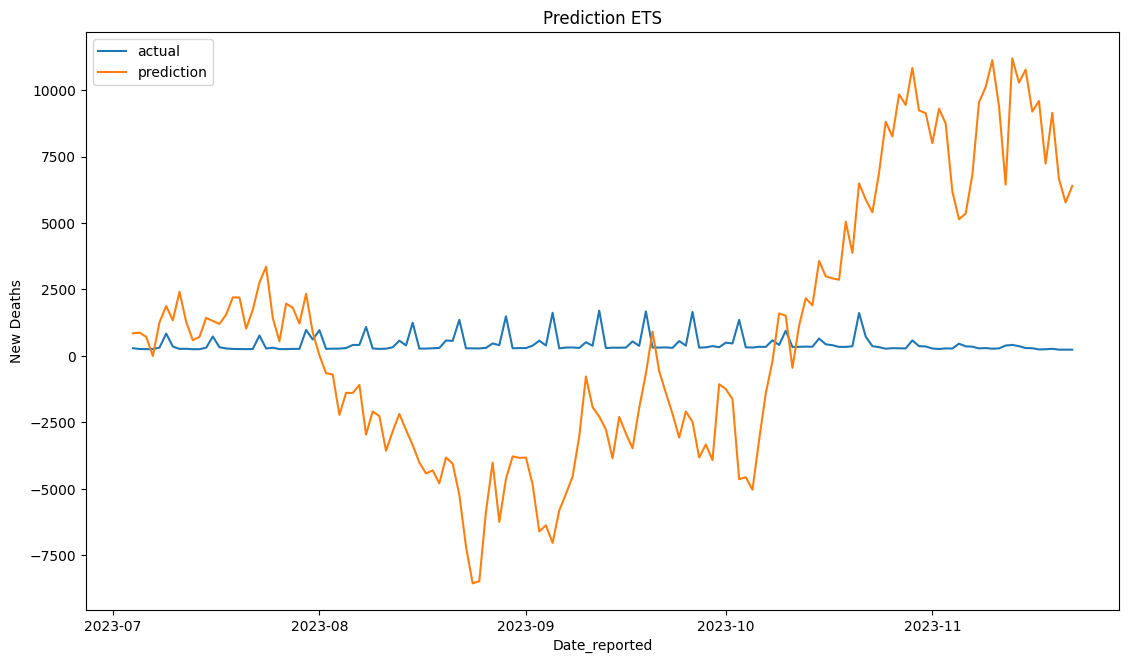

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(p[date_column], p[target_column], label="actual")
ax.plot(p[date_column], p["prediction"], label="prediction")
ax.set_title("Prediction ETS")
ax.set_ylabel("New Deaths")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

In [43]:
print_evaluation_metrics(p["prediction"], p[target_column])

Evaluation Metrics:
MSE: 25197632.55
RMSE: 5019.72
MAE: 4093.44
MAPE: 1179.68
SMAPE: 174.01


In [33]:
store_model(ets, "ets")

In [13]:
param_grid = {"global_trend_option": ["linear", "loglinear", "flat", "logistic"]}
param_values = list(param_grid.values())

all_combinations = list(itertools.product(*param_values))

combinations_as_dicts = [
    dict(zip(param_grid.keys(), combination)) for combination in all_combinations
]

In [29]:
global_trend_options = ["linear", "loglinear", "flat", "logistic"]

dlt_scores = dict()


def dlt_function(grid: Dict[str, Any], date_column: str, target_column: str):
    """
    Create an DLT model with the specified parameters.

    Parameters:
    - grid (Dict[str, Any]): A dictionary containing the parameters for the ETS model.
    - date_column (str): The name of the date column.
    - target_column (str): The name of the target column.

    Returns:
    - An instance of the DLT model configured with the given parameters.
    """
    return DLT(
        date_col=date_column,
        response_col=target_column,
        prediction_percentiles=[5, 95],
        regressor_col=["New_cases_30_days_ago"],
        regressor_sign=["+"],
        regression_penalty="auto_ridge",
        damped_factor=0.8,
        seed=2,
        verbose=False,
        **ets_best_params,
        **grid
    )


with ThreadPoolExecutor(max_workers=4) as executor:
    futures = {
        executor.submit(
            evaluate_grid, dlt_function, option, train, date_column, target_column
        ): option
        for option in combinations_as_dicts
    }
    for future in concurrent.futures.as_completed(futures):
        option, score = future.result()
        dlt_scores[json.dumps(option)] = score

TypeError: orbit.models.dlt.DLT() got multiple values for keyword argument 'seasonality'

In [45]:
dlt_best_params = json.loads(min(dlt_scores, key=dlt_scores.get))
dlt_best_params

In [46]:
dlt = DLT(
    date_col=date_column,
    response_col=target_column,
    prediction_percentiles=[5, 95],
    regressor_col=["New_cases_30_days_ago"],
    regressor_sign=["+"],
    regression_penalty="auto_ridge",
    damped_factor=0.8,
    seed=2,
    verbose=False,
    **ets_best_params,
    **dlt_best_params
)

dlt.fit(train)


chain 1 |          | 00:00 Status






chain 1 |█████     | 00:12 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |███████▌  | 00:14 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:15 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 00:16 Iteration: 226 / 250 [ 90%]  (Sampling)


chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     

In [47]:
p = dlt.predict(df=test[[date_column, "New_cases_30_days_ago"]])
p = p.merge(test, on=date_column, how="left")

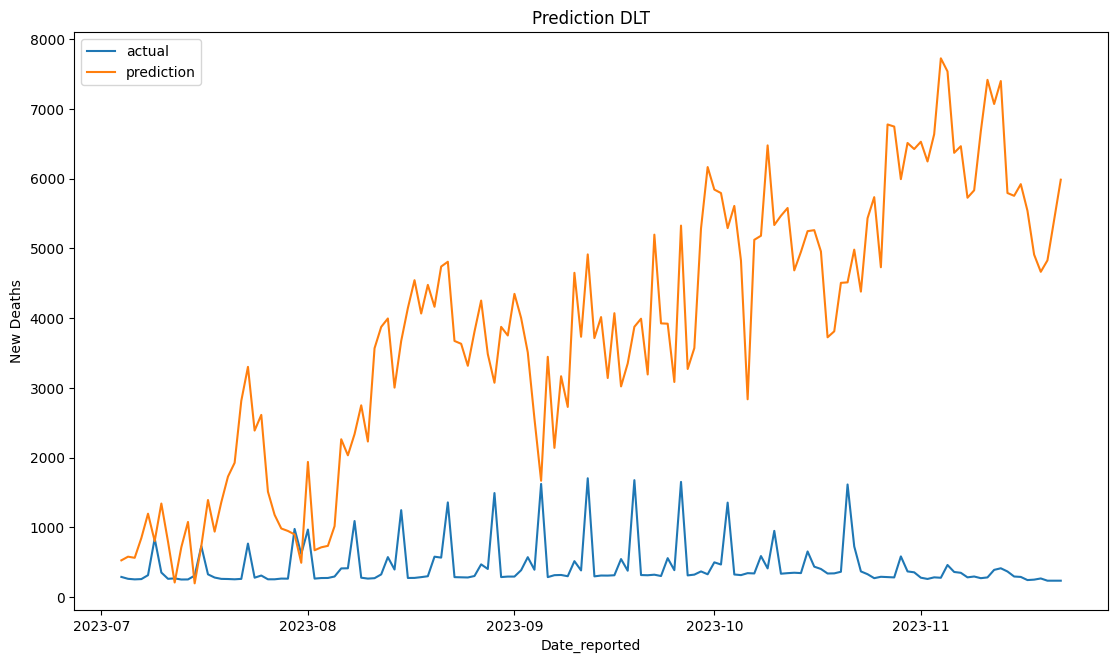

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(p[date_column], p[target_column], label="actual")
ax.plot(p[date_column], p["prediction"], label="prediction")
ax.set_title("Prediction DLT")
ax.set_ylabel("New Deaths")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

In [54]:
print_evaluation_metrics(p["prediction"], p[target_column])

Evaluation Metrics:
MSE: 15234775.70
RMSE: 3903.18
MAE: 3397.01
MAPE: 975.84
SMAPE: 146.39


In [50]:
store_model(dlt, "dlt")

In [20]:
seasonality = [7, 14, 30, 90, 180, 360]

def all_possible_sublists(lst):
    n = len(lst)
    sublists = []
     
    for start in range(n):
        for end in range(start + 1, n + 1):
            sublists.append(lst[start:end])
     
    return sublists


sublists = all_possible_sublists(seasonality)
param_grid = {"seasonality": sublists, "seed": [1,2,3,4,5]}
param_values = list(param_grid.values())

all_combinations = list(itertools.product(*param_values))

combinations_as_dicts = [
    dict(zip(param_grid.keys(), combination)) for combination in all_combinations
]

In [22]:
ktr_scores = dict()


def ktr_function(grid: Dict[str, Any], date_column: str, target_column: str):
    """
    Create an DLT model with the specified parameters.

    Parameters:
    - grid (Dict[str, Any]): A dictionary containing the parameters for the ETS model.
    - date_column (str): The name of the date column.
    - target_column (str): The name of the target column.

    Returns:
    - An instance of the DLT model configured with the given parameters.
    """
    return KTR(
    date_col=date_column,
    response_col=target_column,
    prediction_percentiles=[5, 95],
    regressor_col=["New_cases_30_days_ago"],
    verbose=False,
    **grid
)


with ThreadPoolExecutor(max_workers=4) as executor:
    futures = {
        executor.submit(
            evaluate_grid, ktr_function, option, train, date_column, target_column
        ): option
        for option in combinations_as_dicts
    }
    for future in concurrent.futures.as_completed(futures):
        option, score = future.result()
        ktr_scores[json.dumps(option)] = score

2024-03-31 19:16:12 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.


/home/samuell/.local/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)
2024-03-31 19:16:17 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.
2024-03-31 19:16:21 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.
2024-03-31 19:16:26 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.
2024-03-31 19:16:30 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.
2024-03-31 19:16:34 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm

In [24]:
ktr_best_params = json.loads(min(ktr_scores, key=ktr_scores.get))
ktr_best_params

{'seasonality': [14, 30], 'seed': 3}

In [25]:
ktr = KTR(
    date_col=date_column,
    response_col=target_column,
    prediction_percentiles=[5, 95],
    regressor_col=["New_cases_30_days_ago"],
    verbose=False,
    **ktr_best_params
)

ktr.fit(df=train)

2024-03-31 21:05:37 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.


In [60]:
p = ktr.predict(df=test[[date_column, "New_cases_30_days_ago"]])
p = p.merge(test, on=date_column, how="left")

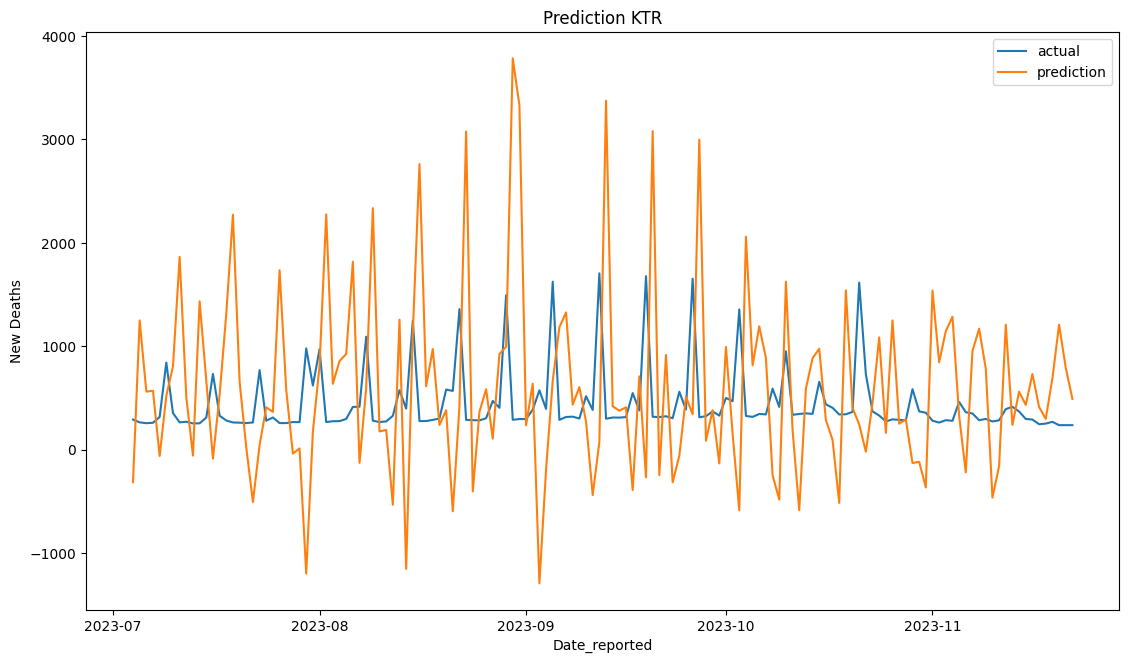

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(p[date_column], p[target_column], label="actual")
ax.plot(p[date_column], p["prediction"], label="prediction")
ax.set_title("Prediction KTR")
ax.set_ylabel("New Deaths")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

In [62]:
print_evaluation_metrics(p["prediction"], p[target_column])

Evaluation Metrics:
MSE: 1027807.11
RMSE: 1013.81
MAE: 733.65
MAPE: 204.11
SMAPE: 113.44


In [59]:
store_model(ktr, "ktr")